In [111]:
import serial
import time
import pyvisa
import sys
import numpy as np
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import clear_output
from datetime import datetime

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [112]:
###############################
##Specify SA GPIB address######
Spectrum = "GPIB0::0::0::INSTR"
###############################

In [113]:
#HP 8560A command set
SET_HP_CENTER_FREQ = "CF "
GET_HP_CENTER_FREQ = "CF?"

In [114]:
###############################
##Spectrum capture parameters##
spectrumCenter = "2440000000"
spectrumSpan = "100000000"
spectrumRBW = "1000000"
spectrumReferenceLevel = "10"
###############################

In [115]:
#HP8560A
#Spectrum analyzer setup
rm = pyvisa.ResourceManager()
instrument = rm.open_resource(Spectrum)

instrument.timeout = 20000

In [116]:
instrument.write("CF?")
spectrumCenter = instrument.read().rstrip()

instrument.write("SP?")
spectrumSpan = instrument.read().rstrip()

instrument.write("RB?")
spectrumRBW = instrument.read().rstrip()

instrument.write("RL?")
spectrumReferenceLevel = instrument.read().rstrip()


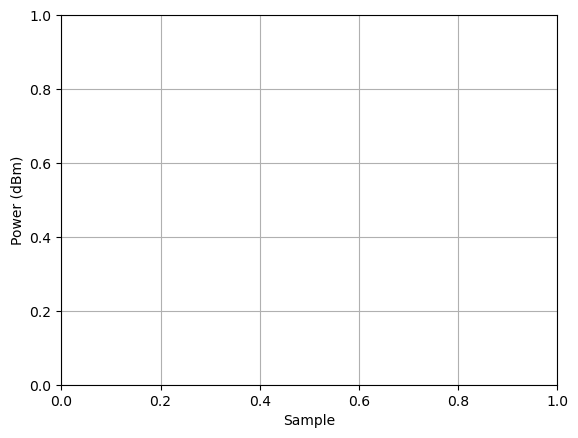

In [117]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
ax.set(xlabel='Sample', ylabel='Power (dBm)')
ax.grid()

df = pd.DataFrame(columns=range(2), index=range(601))
frequencies = range(int(float(spectrumCenter)) - int(float(spectrumSpan))//2, int(float(spectrumCenter)) + int(float(spectrumSpan))//2, int(float(spectrumSpan))//600)
df[0] = frequencies
df = df.astype(float)
df1 = df.set_index(0)

for i in range(10):
# Get Spectrum trace
    instrument.write("TRA?")
    trace_data = instrument.read()
    trace_data = trace_data[0:len(trace_data)-1]
    data = trace_data.split(",")
    data = [float(value) for value in data]
    time.sleep(0.15)

    #x = np.linspace(0, i, len(data));
    #ax.set_xlim(0, i)
    #ax.cla()
    #ax.plot(df1.index, data)
    
    #ax.set_ylim(-100, 10)
    #ax.set_yticks(range(-120, int(spectrumReferenceLevel)+10, 10))
    #plt.grid(True)
    
    #display(fig)
    clear_output(wait = True)


In [118]:
instrument.close()